This notebook is to support .py modules written later.

**Libraries**

In [1]:
#Plotting tools
import matplotlib.pyplot as plt
from plot_tools import (
    plot_multiple
)

In [2]:
from read_raster import Raster
from misc.general import (
    htrim_3d
)

**Prepare files**

In [3]:
main_path = ""

In [4]:
pre_path   = "S2C_MSIL2A_20250609T192931_N0511_R142_T09UYU_20250610T002612_cloudfree.bin_MRAP_C11659.bin_crop.bin"
post_path  = "S2A_MSIL2A_20251009T193831_N0511_R142_T09UYU_20251009T234613_cloudfree.bin_MRAP_C11659.bin_crop.bin"

**Raster instances**

In [5]:
raster_1_instance = Raster(main_path + pre_path)
raster_2_instance = Raster(main_path + post_path)

**Acquisition Date**

In [8]:
pre_date = raster_1_instance.acquisition_timestamp
post_date = raster_2_instance.acquisition_timestamp

**Read raster and TRIM**

In [9]:
raster_1 = raster_1_instance.readBands_and_trim()
raster_2 = raster_2_instance.readBands_and_trim()

**Plot Rasters**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55409455..4.335951].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71518314..7.9960155].


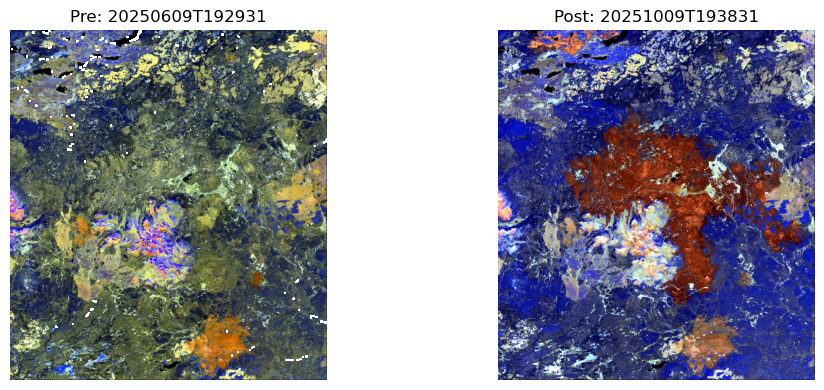

In [10]:
plot_multiple(
    [raster_1, raster_2],
    title_list=[f"Pre: {pre_date}", f"Post: {post_date}"],
    max_per_row=2,
    figsize=(11,4)
)

**Who is larger Thresholding -> File: image_threshold.py**

This module receives **1 image**, with a chosen channel for thresholding.

The channel will be compared against the other channels, it returns 1 if larger, 0 if smaller or equal.

The resulting image is a Black and White img, basically boolean.

In [11]:
from dominant_band import plot_dominant_band

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55409455..4.335951].


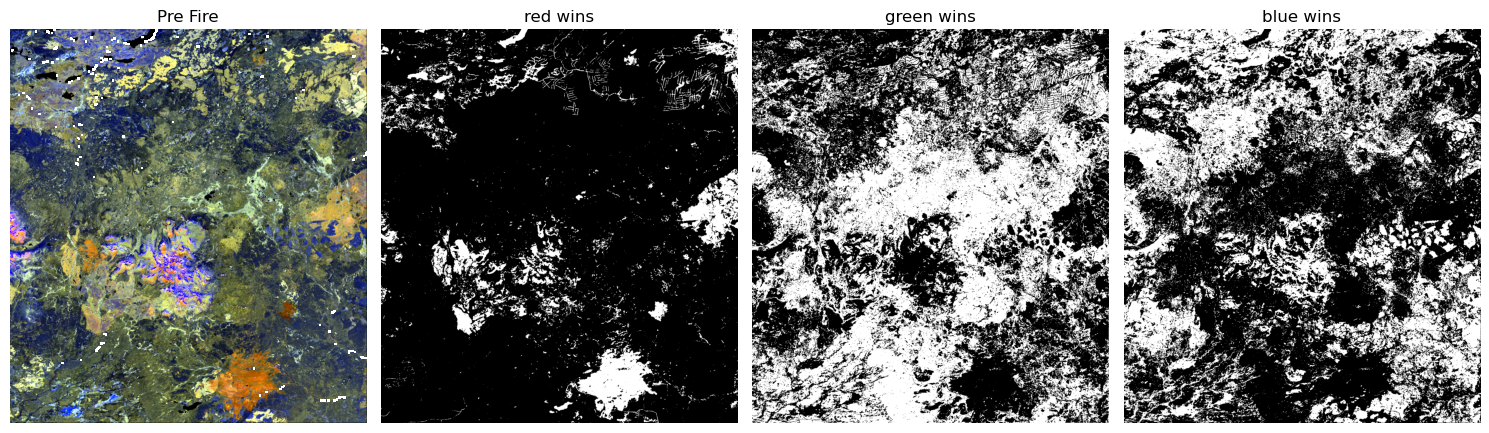

In [12]:
plot_dominant_band(raster_1, 
                   title='Pre Fire')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71518314..7.9960155].


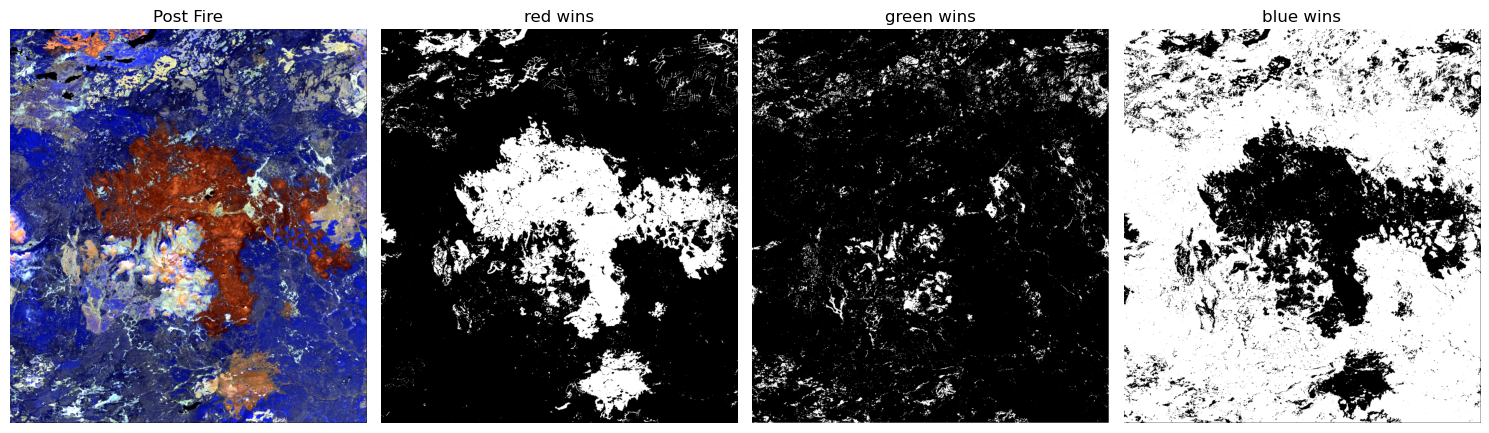

In [13]:
plot_dominant_band(raster_2, 
                   title='Post Fire')

**Change detection**

After the fire, how does each channel change?

In [14]:
from change_detection import change_detection

In [15]:
change = change_detection(
    raster_1,
    raster_2
)

htrim_change = htrim_3d(change, p = 1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55409455..4.335951].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71518314..7.9960155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-50903.855..57007.656].


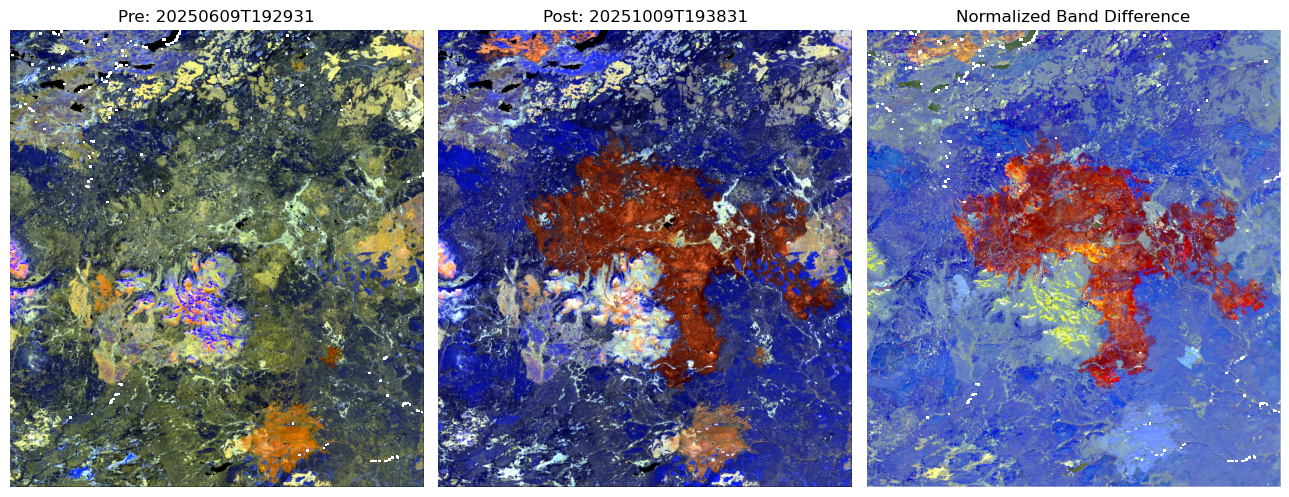

In [16]:
plot_multiple(
    X_list = [raster_1, raster_2, htrim_change],
    title_list = [f'Pre: {pre_date}', 
                f'Post: {post_date}',
                'Normalized Band Difference'],
    max_per_row=3,
    figsize=(13, 10)
)

**BARC PLOT**

**Get Band Data**

For BARC, we need band 8 (NIR) and band 12 (SWIR)

In [17]:
B8_pre = raster_1_instance.get_band(8)
B8_post = raster_2_instance.get_band(8)

In [18]:
B12_pre = raster_1_instance.get_band(12)
B12_post = raster_2_instance.get_band(12)

**NBR (Normalized Burn Ratio)**

Formula: 
$$
NBR = \frac{B8 - B12}{B8 + B12}
$$

Healthy vegetation exhibits an **intact internal leaf cell structure**, which causes strong multiple scattering of radiation in the **NIR**, resulting in **high NIR reflectance**.

In contrast, **SWIR reflectance is strongly influenced by leaf water content**: vegetation with higher water content absorbs more SWIR energy and therefore exhibits **lower SWIR reflectance**.


+ As a result, **the healthier the vegetation, the stronger the spectral contrast between NIR and SWIR**, and thus the clearer the separation captured by NBR. 

+ **Vegetation that is already stressed, sparse, or senescent—even in the absence of fire** may exhibit a reduced NIR–SWIR contrast, producing **weaker or ambiguous NBR responses**.

**Differenced Normalized Burn Ratio**

Since the formula of NBR, the formula of dNBR is pre - post, as illustrated below.

$$
dNBR = NBR_{pre} - NBR_{post}
$$

A **positive dNBR (> 0)** indicates a decrease in NBR after the event, which can—but does not necessarily—correspond to fire-induced change.

As discussed previously, vegetation that is already stressed or sparse (even without fire) may exhibit a weak NIR–SWIR contrast and therefore a low NBR. Consequently, **changes in phenology, moisture conditions, or land cover unrelated to fire** can also produce **positive dNBR values**.

<u>However, in a typical fire scenario:</u>

+ Pre-fire: healthy vegetation → high NIR, low SWIR → high NBR

+ Post-fire: damaged or removed vegetation → low NIR, high SWIR → low NBR

Later on, by having a look at the BARC plot, we will understand more.

In [64]:
from nbr import dNBR

In [65]:
nbr_pre, nbr_post, dnbr = dNBR(NIR_1=B8_pre, SWIR_1=B12_pre,
            NIR_2=B8_post, SWIR_2=B12_post)

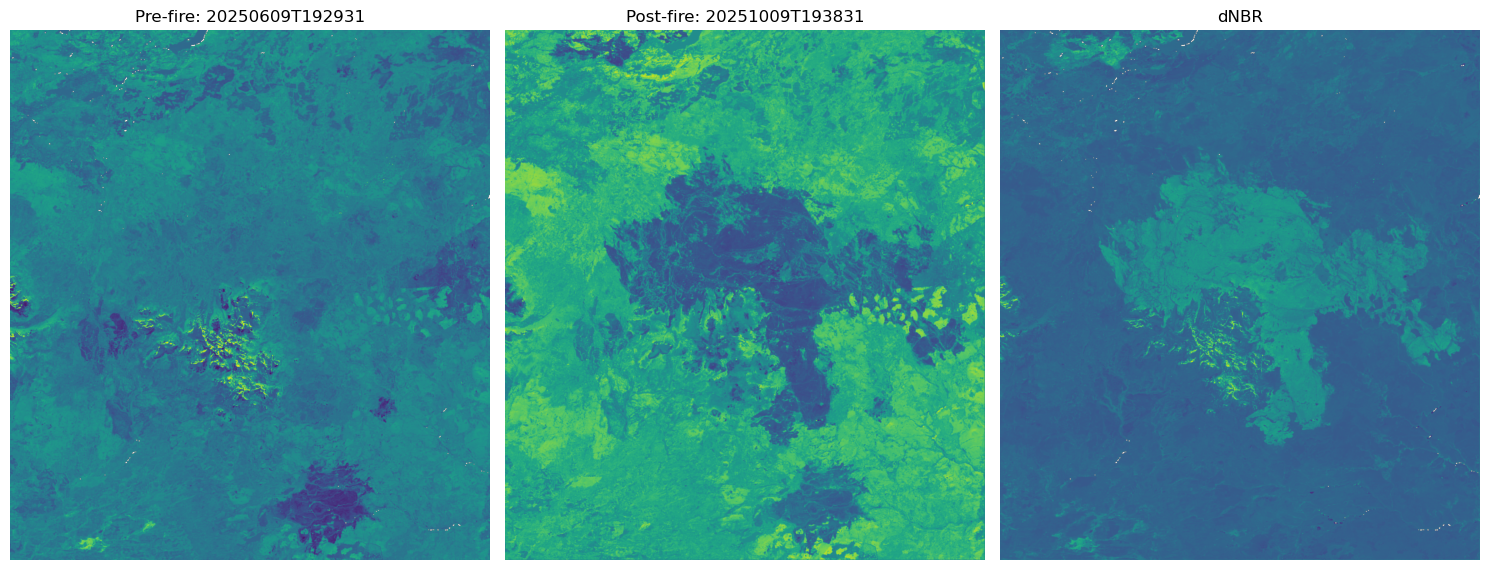

In [66]:
plot_multiple(
    [nbr_pre, nbr_post, dnbr],
    title_list=[f'Pre-fire: {pre_date}', f'Post-fire: {post_date}', 'dNBR'],
    figsize=(15, 8),
    max_per_row=3
)

**BARC (Burned Area Reflectance Classification)**

In [91]:
from nbr import plot_barc

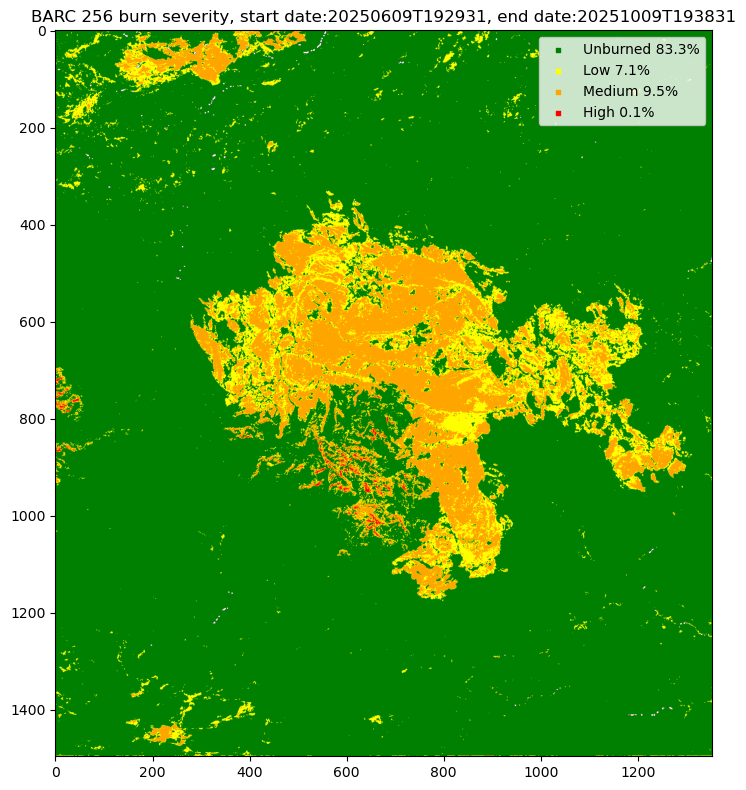

In [100]:
plot_barc(dnbr, start_date=pre_date, end_date=post_date, figsize=(8, 8))